# **RFM ANALYSIS** 
## **1. Goal**
To segment customers based on their purchasing behavior using the RFM framework and develop data-driven, actionable marketing strategies for each customer segment.

## **2. Key Results**
**Time range:** 2010-12-01 to 2011-12-09

|Segment Name | % Shared Users |  Key Behavioral | Description | Marketing Objective | Marketing Actions |
|---------------|--------------|----------------|-------------|--------------------|-------------------|
| Early Life| 17.6%  | DSLO ≈ 27 days; Total Orders ≈ 2; AMM ≈ £52 | Recently active but low purchase intensity. Growth and nurturing opportunity. |Help customers build a consistent shopping habit by encouraging more frequent purchases in the | Double Day & Payday campaigns; 1st-to-2nd and 2nd-to-3rd purchase rewards; Daily check-in incentives|
| Mature| 17.1%  | DSLO ≈ 15 days; Total Orders ≈ 15; AMM ≈ £493 | Highly active, high-spending customers. Core revenue drivers with strong engagement. | Maintain engagement and strengthen loyalty among these high-value users. | Loyalty/VIP tiers; Exclusive offers; Upsell & cross-sell; Reward-based retention programs; Engagement gamification. |
| Prevent Churn| 29.0%  | DSLO ≈ 89 days; Total Orders ≈ 5; AMM ≈ £159 |  Moderately active customers showing early signs of disengagement. Require proactive retention. | Re-engage and prevent customers from slipping into full inactivity. | Comeback vouchers; Email/push reminders; Re-engagement campaigns during seasonal events|
| Churn| 36.3%  | DSLO ≈ 266 days; Total Orders ≈ 1; AMM ≈ £34 |Inactive and low-value customers with high churn probability.| Reactivate selectively while maintaining marketing efficiency and cost control.  | Targeted win-back campaigns; Email/push reminders|
## **3. Further Analysis - Golden Number Analysis**
**Goal:**
To identify the purchase milestone at which customers begin to form stable shopping habits, churn rate is analyzed across cumulative order counts.

The analysis aims to detect a significant drop in churn probability after a certain purchase threshold (aka 'Golden Number'), indicating behavioral stabilization and stronger retention patterns.

**Strategy:**

Once the Golden Number is identified, marketing efforts should focus on accelerating customers toward this milestone.
Campaigns and incentives can be tailored to encourage repeat purchases until customers reach this critical order count

---
## **4. Method**
- **RFM Analysis** to quantify customer behavior.
- **Log transformation** to stabilize skewed distributions.
- **Feature scaling (Standardization)** to normalize variables before clustering.
- **Elbow Method & Silhouette Score** to determine the optimal number of clusters.
- **K-Means clustering** to categorize customers into distinct segments.
- **Cluster profiling & CRM lifecycle** to convert clusters into business-relevant lifecycle segments.
## **5. Main Steps**

- **Data Quality Check**: Assess missing values, duplicates, invalid records, and cancelled transactions, etc.
- **Data Cleaning**: Remove duplicates, exclude cancelled and invalid transactions.
- **Build RFM Table**: Calculate Recency, Frequency, and Monetary at customer level.
- **RFM Skewness Check**: Identify whether data is strong skewness in any RFM, to be well prepare before apply Kmean
- **Log Transformation & Scaling**
- **K-Means Clustering**: Use Elbow Method and Silhouette Score to select optimal K.
- **User Profiling & CRM Lifecycle**: Translate clusters into lifecycle segments:
     - Early Life
     - Mature
     - Prevent Churn
     - Churn

In [1]:
#Import all needed libraries 
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_theme()
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
txn_df = pd.read_csv('transactions_data.csv')
txn_df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536368,22960,JAM MAKING SET WITH JARS,6,12/1/2010 8:34,4.25,13047.0,United Kingdom


## **1. DATA QUALITY CHECK**

In [3]:
txn_df.info()
#Noted a mismatch between total transactions (541,910) and records with CustomerID (406,830). 
#>> missing value, requiring further investigation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      541910 non-null  object 
 1   StockCode    541910 non-null  object 
 2   Description  540456 non-null  object 
 3   Quantity     541910 non-null  int64  
 4   InvoiceDate  541910 non-null  object 
 5   Price        541910 non-null  float64
 6   Customer ID  406830 non-null  float64
 7   Country      541910 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
txn_df.describe()
#quantity and price columns contain negative values.
#this may indicate cancelled transactions, returns, or data entry issues.
#>>further investigation is required

,Quantity,Price,Customer ID
count,541910.000000,541910.000000,406830.000000
mean,9.552234,4.611138,15287.684160
std,218.080957,96.759765,1713.603074
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
#Check duplicated
#Check missing value
#Check cancel/return order
####################################
total_rows = len(txn_df)

#Check duplicated
cnt_dup = txn_df.duplicated().sum()
pct_dup = cnt_dup / total_rows * 100

#Check missing CustomerID
cnt_missing_uid = txn_df['Customer ID'].isna().sum()
pct_missing_uid = cnt_missing_uid / total_rows * 100

#Check cancelled orders (Invoice starts with the letter 'c')
filter_cancelled_orders = txn_df['Invoice'].str.startswith('C')
cnt_cancelled_orders = filter_cancelled_orders.sum()
pct_cancelled_orders = cnt_cancelled_orders / total_rows * 100

#Check orders with Quantity <= 0
filter_qty_negative = txn_df['Quantity'] <= 0
cnt_qty_negative = filter_qty_negative.sum()
pct_qty_negative = cnt_qty_negative / total_rows * 100

#Check orders with Price <= 0
filter_price_negative = txn_df['Price'] <= 0
cnt_price_negative = filter_price_negative.sum()
pct_price_negative = cnt_price_negative / total_rows * 100

summary = pd.DataFrame({'Infor': ['Total rows'
                                  ,'Duplicated rows'
                                  ,'Missing CustomerID'
                                  ,'Cancelled orders'
                                  ,'Orders with Quantity <= 0'
                                  ,'Orders with Price <= 0']
                        ,'Count': [total_rows
                                  ,cnt_dup
                                  ,cnt_missing_uid
                                  ,cnt_cancelled_orders
                                  ,cnt_qty_negative
                                  ,cnt_price_negative]
                        ,"Percentage %": [ 1
                                        ,pct_dup
                                        ,pct_missing_uid
                                        ,pct_cancelled_orders
                                        ,pct_qty_negative
                                        ,pct_price_negative]
                        })
summary

,Infor,Count,Percentage %
0,Total rows,541910,1.000000
1,Duplicated rows,5268,0.972117
2,Missing CustomerID,135080,24.926648
3,Cancelled orders,9288,1.713938
4,Orders with Quantity <= 0,10624,1.960473
5,Orders with Price <= 0,2517,0.464468


Since the objective is actionable marketing segmentation, only valid transactions associated with identifiable customers will be retained, and to ensure analytical accuracy and business relevance, the following actions will be taken:
- **Removed duplicated rows (~0.97%)** to prevent double-counting.
- **Excluded cancelled transactions and invalid records where Quantity <= 0 or Price <= 0 (~1.96% and 0.46 respectively)** as they do not represent a valid purchasing behavior.
- **Removed records with missing values in the CustomerID column (~24.93%)** to enable accurate customer-level aggregation later on.

Although nearly 25% of transactions lack CustomerID (from my point of view, it is a substantial proportion), removing these records is methodologically necessary to ensure accurate and actionable segmentation outcomes (further marketing strategies).




## **2. DATA CLEANING**

In [6]:
#Remove duplicated rows
txn_clean_df = txn_df.drop_duplicates()
#Remove cancelled orders
txn_clean_df = txn_clean_df[~txn_clean_df['Invoice'].str.startswith('C')]
#Remove invalid records (Quantity <= 0 or UnitPrice <= 0)
txn_clean_df = txn_clean_df[(txn_clean_df['Quantity'] > 0) & (txn_clean_df['Price'] > 0)]
#Remove records with missing CustomerID
txn_clean_df = txn_clean_df[txn_clean_df['Customer ID'].notna()]
final_rows = len(txn_clean_df)

print('Initial rows:', total_rows)
print('Final rows after cleaning:', final_rows)
print('Rows removed:', total_rows - final_rows)
print('Percentage removed: {:.2f}%'.format((total_rows - final_rows) / total_rows * 100))

Initial rows: 541910
Final rows after cleaning: 392693
Rows removed: 149217
Percentage removed: 27.54%


## **3. CREATE RFM TABLE**

In [7]:
#Check the time range after cleaning data 
txn_clean_df['InvoiceDate'] = pd.to_datetime(txn_clean_df['InvoiceDate'])
print('Start date:' , txn_clean_df['InvoiceDate'].min())
print('End date:' , txn_clean_df['InvoiceDate'].max())

Start date: 2010-12-01 08:26:00
End date: 2011-12-09 12:50:00


In [8]:
#To calculate the Recency, I define the snapshot date as one day after the last observed transaction date 
snapshot_date = txn_clean_df['InvoiceDate'].max() + pd.Timedelta(days=1)

In [9]:
txn_clean_df['GMV'] = txn_clean_df['Quantity'] * txn_clean_df['Price']
#RFM table - Aggregate data by customer level
rfm = txn_clean_df.groupby('Customer ID').agg({
                                    'InvoiceDate': lambda x: (snapshot_date-x.max()).days,
                                    'Invoice': 'nunique',
                                    'GMV': 'sum'
                                })
rfm.rename(columns={'InvoiceDate': 'Recency', 
                         'Invoice': 'Frequency', 
                         'GMV': 'Monetary'}, inplace=True)
rfm

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40
...,...,...,...
18280.0,278,1,180.60
18281.0,181,1,80.82
18282.0,8,2,178.05


## **4. RFM EDA AND SKEWNESS CHECK**
Before applying clustering on RFM metrics, it is important to check their distribution, particularly skewness.

In this analysis, K-Means is used to segment customers based on RFM values.

FYI, K-Means is a distance-based algorithm that optimizes cluster centroids by minimizing the within-cluster sum of squared errors.

Because it relies on distance, each feature contributes directly to the distance calculation.
If one variable has a much larger scale or is highly skewed, it can dominate the distance computation and influence centroid positions, such as Monetary. As a result, clustering may primarily reflect user's spending rather than overall customer behavior across Recency, Frequency and Monetary.

Therefore, checking skewness helps determine whether transformation and feature standardization are required.


In [10]:
rfm.describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2048.692230
std,100.014169,7.697998,8985.229676
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,306.482500
50%,51.000000,2.000000,668.570000
75%,142.000000,5.000000,1660.597500
max,374.000000,209.000000,280206.020000


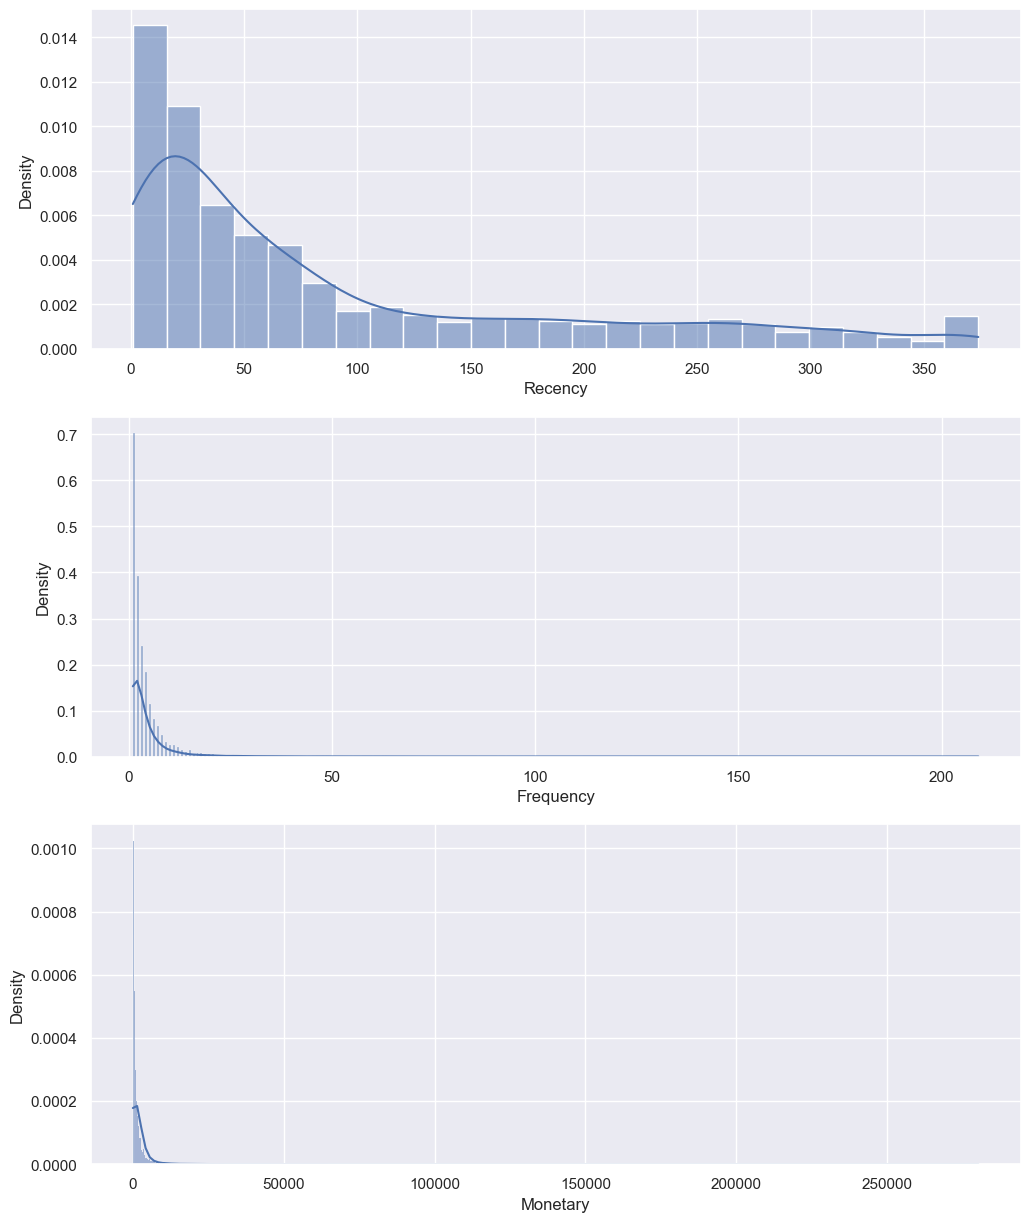

In [11]:
plt.figure(figsize=(12,15))
#Recency distribution
plt.subplot(3, 1, 1); sns.histplot(rfm['Recency'], kde=True, stat="density")
#Frequency distribution
plt.subplot(3, 1, 2); sns.histplot(rfm['Frequency'], kde=True, stat="density")
#Monetary value distribution
plt.subplot(3, 1, 3); sns.histplot(rfm['Monetary'], kde=True, stat="density")
plt.show()

In [12]:
#Check original skewness
rfm[['Recency','Frequency','Monetary']].skew()

Recency       1.246048
Frequency    12.067031
Monetary     19.339370
dtype: float64

## RFM Distribution Insights

### Frequency
+ Frequency shows strong concentration at low values (median = 2; 75% ≤ 5 orders) with a maximum of 209 orders.  
+ The skewness is 12.07, indicating a highly right-skewed distribution driven by a small group of very frequent buyers.

### Monetary
+ Monetary exhibits extreme dispersion with the high standard deviation (std = 8985).
+ The skewness is 19.34, large gap between mean and median, along with the the high standard deviation, confirms the presence of high-value customers

---

All RFM variables exhibit right-skewed distributions, particularly Frequency and Monetary.

To address this, as discussed above:
+ Log transformation is applied to compress extreme values, stabilize the distribution, reducing the impact of high-value
+ Scaling (feature standardization) will be applied to ensure each feature contributes equally to the distance-based clustering process.


## **5. LOG TRANSFORMATION AND FEATURE SCALING**

In [13]:
rfm['Recency_Log'] = rfm['Recency'].apply(lambda row: np.log(row))
rfm['Frequency_Log'] = rfm['Frequency'].apply(lambda row: np.log(row))
rfm['Monetary_Log'] = rfm['Monetary'].apply(lambda row: np.log(row))
rfm

,Recency,Frequency,Monetary,Recency_Log,Frequency_Log,Monetary_Log
Customer ID,,,,,,
12346.0,326,1,77183.60,5.786897,0.000000,11.253942
12347.0,2,7,4310.00,0.693147,1.945910,8.368693
12348.0,75,4,1797.24,4.317488,1.386294,7.494007
12349.0,19,1,1757.55,2.944439,0.000000,7.471676
12350.0,310,1,334.40,5.736572,0.000000,5.812338
...,...,...,...,...,...,...
18280.0,278,1,180.60,5.627621,0.000000,5.196285
18281.0,181,1,80.82,5.198497,0.000000,4.392224
18282.0,8,2,178.05,2.079442,0.693147,5.182064


In [14]:
print('Skew before log:')
print(rfm[['Recency','Frequency','Monetary']].skew())
print('\nSkew after log:')
print(rfm[['Recency_Log','Frequency_Log','Monetary_Log']].skew())

Skew before log:
Recency       1.246048
Frequency    12.067031
Monetary     19.339370
dtype: float64

Skew after log:
Recency_Log     -0.554566
Frequency_Log    0.783727
Monetary_Log     0.383994
dtype: float64


In [15]:
#Standardize the data - Bring data into the same scale for apply KMeans
scale = StandardScaler()
rfm_scale = scale.fit_transform(rfm[['Recency_Log','Frequency_Log','Monetary_Log']])
rfm[['Recency_Scaled','Frequency_Scaled','Monetary_Scaled']] = rfm_scale
rfm

,Recency,Frequency,Monetary,Recency_Log,Frequency_Log,Monetary_Log,Recency_Scaled,Frequency_Scaled,Monetary_Scaled
Customer ID,,,,,,,,,
12346.0,326,1,77183.60,5.786897,0.000000,11.253942,1.409894,-1.048610,3.700195
12347.0,2,7,4310.00,0.693147,1.945910,8.368693,-2.146498,1.111836,1.413252
12348.0,75,4,1797.24,4.317488,1.386294,7.494007,0.383971,0.490522,0.719947
12349.0,19,1,1757.55,2.944439,0.000000,7.471676,-0.574674,-1.048610,0.702247
12350.0,310,1,334.40,5.736572,0.000000,5.812338,1.374758,-1.048610,-0.612999
...,...,...,...,...,...,...,...,...,...
18280.0,278,1,180.60,5.627621,0.000000,5.196285,1.298690,-1.048610,-1.101303
18281.0,181,1,80.82,5.198497,0.000000,4.392224,0.999081,-1.048610,-1.738628
18282.0,8,2,178.05,2.079442,0.693147,5.182064,-1.178605,-0.279044,-1.112575


In [16]:
#Check result after scaling
print('Mean of RFM after scaling:')
print(rfm[['Recency_Scaled','Frequency_Scaled','Monetary_Scaled']].mean().round(2))
print('\nStd of RFM after scaling:')
print(rfm[['Recency_Scaled','Frequency_Scaled','Monetary_Scaled']].std().round(2))

Mean of RFM after scaling:
Recency_Scaled     -0.0
Frequency_Scaled   -0.0
Monetary_Scaled     0.0
dtype: float64

Std of RFM after scaling:
Recency_Scaled      1.0
Frequency_Scaled    1.0
Monetary_Scaled     1.0
dtype: float64


Since the RFM features after scaling have a mean approximately equal to 0 and a standard deviation close to 1, the data is properly ready for K-Means clustering.

## **6. K-MEANS CLUSTERING**

 ### **6.1. Elbow method and Silhouette Score**
 
Since K-Means requires the number of clusters to be specified in advance, the Elbow Method is used to determine a reasonable value of K. 

By plotting inertia across different values of K, we look for the point where the curve begins to flatten. This indicates that adding more clusters no longer provides significant improvement in reducing the Sum of Squared Errors (SSE).

When more than one K value appears reasonable (in this analysis, K = 4 and K = 5), the Silhouette Score is used as an additional metric to evaluate how well the clusters are separated.

The final selection of K is based on a balance between meaningful reduction in inertia and a higher Silhouette Score.

*FYI: The Silhouette Score measures how well each data point fits within its assigned cluster compared to other clusters. A higher score indicates better-defined and more clearly separated clusters.*


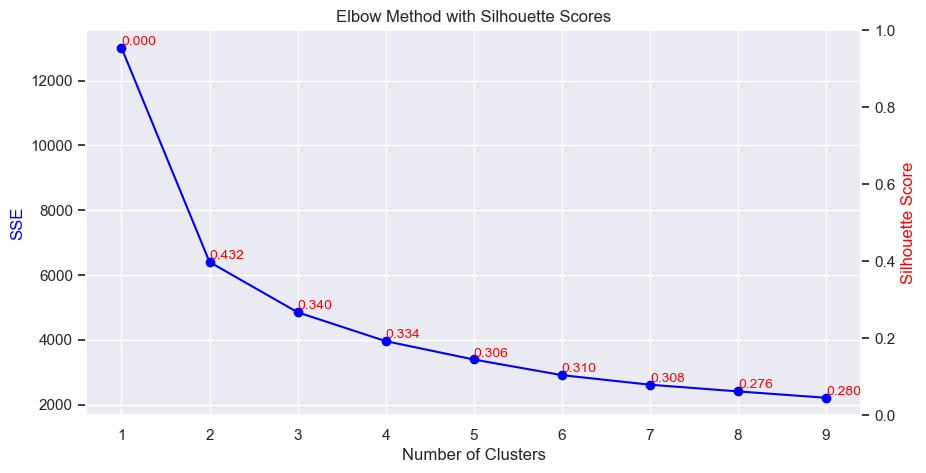

In [17]:
SSE = []
sil_scores = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(rfm[['Recency_Scaled','Frequency_Scaled','Monetary_Scaled']])
    SSE.append(kmeans.inertia_)
    #Silhouette Score is undefined for K = 1 
    #Because when there is only 1 cluster, we have no other clusters to compare against.
    if k == 1:
        sil_scores.append(0)
    else:
        sil_scores.append(silhouette_score(rfm[['Recency_Scaled','Frequency_Scaled','Monetary_Scaled']], labels))

fig, ax1 = plt.subplots(figsize = (10,5))
# Plot SSE
ax1.plot(K, SSE, 'o-', color = 'blue')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('SSE', color ='blue')
# Create right axis
ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color ='red')
ax2.grid(False)
for i, k in enumerate(K):
    ax1.text(k, SSE[i]
             ,f'{sil_scores[i]:.3f}'
             ,ha = 'left'
             ,va = 'bottom'
             ,fontsize = 10
             ,color = 'red')
plt.title('Elbow Method with Silhouette Scores')
plt.show()

As aforementioned rationales, the final selection of K is based on a balance between meaningful reduction in SSE and a higher Silhouette Score.

Therefore, K = 4 is selected as it provides better-defined, more cohesive.


### **6.2. Apply Kmean with 4 clusters**

In [18]:
#Apply Kmean with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm[['Recency_Scaled','Frequency_Scaled','Monetary_Scaled']])
rfm = rfm.reset_index()
rfm

,Customer ID,Recency,Frequency,Monetary,Recency_Log,Frequency_Log,Monetary_Log,Recency_Scaled,Frequency_Scaled,Monetary_Scaled,Cluster
0,12346.0,326,1,77183.60,5.786897,0.000000,11.253942,1.409894,-1.048610,3.700195,3
1,12347.0,2,7,4310.00,0.693147,1.945910,8.368693,-2.146498,1.111836,1.413252,2
2,12348.0,75,4,1797.24,4.317488,1.386294,7.494007,0.383971,0.490522,0.719947,3
3,12349.0,19,1,1757.55,2.944439,0.000000,7.471676,-0.574674,-1.048610,0.702247,0
4,12350.0,310,1,334.40,5.736572,0.000000,5.812338,1.374758,-1.048610,-0.612999,1
...,...,...,...,...,...,...,...,...,...,...,...
4333,18280.0,278,1,180.60,5.627621,0.000000,5.196285,1.298690,-1.048610,-1.101303,1
4334,18281.0,181,1,80.82,5.198497,0.000000,4.392224,0.999081,-1.048610,-1.738628,1
4335,18282.0,8,2,178.05,2.079442,0.693147,5.182064,-1.178605,-0.279044,-1.112575,0
4336,18283.0,4,16,2045.53,1.386294,2.772589,7.623412,-1.662552,2.029655,0.822518,2


## **7. USER PROFILING AND CRM LIFECYCLE**
To profile users, 3 key behavioral metrics are analyzed at the monthly level: 
+ Recency: Days since last order (DSLO)
+ Frequency: Total orders
+ Average Monthly Monetary (AMM): average monthly gmv

DSLO, Total Orders and AMM metrics allow to translate clustering outputs into meaningful CRM lifecycle stages, supporting actionable marketing strategies.

| Cluster |% Shared users| Segment Name | Key Behavioral| Description|
|----------|--------------|--------------|-------------------------------------|----------------------|
| 0 |17.6%| Early Life | DSLO ≈ 27 days; Total Orders ≈ 2; AMM ≈ £52 | Recently active but low purchase intensity. Growth and nurturing opportunity. |
| 2 |17.1%| Mature | DSLO ≈ 15 days; Total Orders ≈ 15; AMM ≈ £493 | Highly active, high-spending customers. Core revenue drivers with strong engagement. |
| 3 |29.0%| Prevent Churn | DSLO ≈ 89 days; Total Orders ≈ 5; AMM ≈ £159 | Moderately active customers showing early signs of disengagement. Require proactive retention.|
| 1 |36.3%| Churn | DSLO ≈ 266 days; Total Orders ≈ 1; AMM ≈ £34 | Inactive and low-value customers with high churn probability.  |

Please find detail as below:

In [19]:
txn_df['InvoiceDate'] = pd.to_datetime(txn_df['InvoiceDate'])
observation_days = (txn_df['InvoiceDate'].max() - txn_df['InvoiceDate'].min()).days
rfm['AMF'] = (rfm['Frequency'] / observation_days) * 30 #average monhtly order
rfm['AMM'] = (rfm['Monetary'] / observation_days)* 30 #average monthly gmv

cluster_profile = (rfm.groupby('Cluster').agg(
                                        cnt_users=('Cluster','count')
                                        ,Recency_p75=('Recency', lambda x: x.quantile(0.75))
                                        ,Frequency_p75=('Frequency', lambda x: x.quantile(0.75))
                                        ,AMF_p75=('AMF', lambda x: x.quantile(0.75))
                                        ,AMM_p75=('AMM', lambda x: x.quantile(0.75))
                                        ).round(2)
                 )
cluster_profile['%_share_users'] = (cluster_profile['cnt_users'] 
                             / cluster_profile['cnt_users'].sum() * 100
                            ).round(1)
cluster_profile

,cnt_users,Recency_p75,Frequency_p75,AMF_p75,AMM_p75,%_share_users
Cluster,,,,,,
0,764,27.0,2.0,0.16,52.10,17.6
1,1573,266.0,1.0,0.08,34.50,36.3
2,741,15.0,15.0,1.21,492.82,17.1
3,1260,89.0,5.0,0.40,159.29,29.0


## **8. MARKETING STRATEGY SUGGESTION**
### Cluster 0 – Early Life
**Profile:** 
+ Customers in this segment have made recent purchases, but they havent built a strong shopping routine yet.
+ They buy occasionally and spend at a lower level, which means there is still **a lot of room to grow and strengthen the relationship.**

**Marketing Strategy:**

**Objective:** Help customers build a consistent shopping habit by encouraging more frequent purchases in the early stage.

- Double Day campaigns (e.g., 9.9, 10.10, 11.11) with attractive vouchers to make shopping feel exciting and rewarding.
- Run Payday promotions around salary periods to match customers's higher purchasing power.
- Provide reward for 1st-to-2nd and 2nd-to-3rd purchases to gently guide them toward repeat buying.
- Introduce daily check-in rewards (points, small vouchers, loyalty credits) to increase daily engagement.
- Create simple weekly missions (e.g. complete 2 purchases to unlock a bonus reward).
- Offer milestone rewards at the 2nd, 3rd, and 4th orders to celebrate progress and reinforce habit formation.

---

### Cluster 2 – Mature
**Profile:** 
+ These customers show the strongest purchasing intensity and revenue contribution. They shop frequently, spend more per month, and are highly engaged with the platform.
+ This group represents the core customer base and plays a key role in sustaining long-term growth.

**Marketing Strategy:**

**Objective:** Maintain engagement and strengthen loyalty among these high-value users.
- Develop loyalty tiers or VIP programs to reward consistent engagement.
- Provide exclusive offers.
- Recommend premium or high-value products through upsell and cross-sell.
- Introduce daily check-in rewards (points, small vouchers, loyalty credits) or simple weekly missions to keep user retention.
---

### Cluster 3 – Prevent Churn
**Profile:**  
+ Customers in this segment used to purchase more actively but have recently slowed down.
+ They still show meaningful spending behavior, but the longer gap between purchases suggests their engagement may be fading.

**Marketing Strategy:**

**Objective:** Re-engage and prevent customers from slipping into full inactivity.
- Use personalized push notifications or emails to bring them back
- Offer personalized comeback vouchers.
- Run re-engagement campaigns during Double Day or seasonal events.
- Provide tailored product recommendations based on their previous purchases.
- Launch short-term 'return missions' (e.g. complete 1 purchase this week to unlock bonus rewards).


---

### Cluster 1 – Churn

**Profile:** 
+ Customers in this segment have not made a purchase for a long period and show very low purchasing intensity.

+ *With an average total order of around 1*, many are likely one-time buyers who never developed a consistent shopping habit. As a result, their probability of returning is relatively low, indicating a high churn risk.

**Marketing Strategy:**

**Objective:** Reactivate selectively while maintaining marketing efficiency and cost control.
- Launch win-back campaigns with an attractive discount (but control cost)
- Use personalized push notifications or emails to bring them back
- Reintroduce best-selling or trending products with limited-time comeback offers.


## **9. FURTHER ANALYSIS - Golden Number Analysis**

**Goal:**  
To identify the purchase milestone at which customers begin to form stable shopping habits, churn rate is analyzed across cumulative order counts.

The analysis aims to detect a significant drop in churn probability after a certain purchase threshold (aka 'Golden Number'), indicating behavioral stabilization and stronger retention patterns.

**Strategy:**  
+ Once the Golden Number is identified, marketing efforts should focus on accelerating customers toward this milestone.
+ Campaigns and incentives can be tailored to encourage repeat purchases until customers reach this critical order count

